In [1]:
!pip install -q torch pytorch-lightning pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.2/828.2 kB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
%cd /content/
!git clone https://github.com/phoeenniixx/Tversky-Layer

/content
Cloning into 'Tversky-Layer'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 41 (delta 12), reused 33 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 12.04 KiB | 12.04 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
import sys
import warnings
import torch
import torch.nn as nn
import lightning.pytorch as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time

sys.path.append('/content/Tversky-Layer')

from src import TverskyProjection

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data.examples import get_stallion_data
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics.point import SMAPE, MASE

pl.seed_everything(42)
data = get_stallion_data()
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

data["month"] = data.date.dt.month.astype(str).astype(
    "category"
)
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(
    ["time_idx", "sku"], observed=True
).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(
    ["time_idx", "agency"], observed=True
).volume.transform("mean")


special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = (
    data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
)
data.sample(10, random_state=521)

max_encoder_length = 60
max_prediction_length = 20
training_cutoff = data["time_idx"].max() - max_prediction_length


max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length
    // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={
        "special_days": special_days
    },
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)

batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)



INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [2]:
class TFTWithTversky(TemporalFusionTransformer):
    """Fixed TFT with Tversky that addresses exploding gradients"""

    def __init__(self, tversky_num_features: int = 5, output_scale: float = 0.01,
                 gradient_clip: float = 1.0, *args, **kwargs):

        super().__init__(*args, **kwargs)

        self.tversky_num_features = tversky_num_features
        self.output_scale = output_scale
        self.gradient_clip = gradient_clip

        original_output = self.output_layer
        if hasattr(original_output, 'in_features'):
            input_dim = original_output.in_features
            output_dim = original_output.out_features
        else:
            input_dim = self.hparams.hidden_size
            output_dim = 1

        self.output_layer = TverskyProjection(
            input_dim=input_dim,
            output_dim=output_dim,
            num_features=tversky_num_features,
            output_scale=output_scale,
            gradient_clip=gradient_clip
        )



In [3]:
def train_and_evaluate_model(model, model_name, train_dl, val_dl, max_epochs=50):
    """Train a model and return evaluation metrics"""
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")

    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=10,
        verbose=False,
        mode="min"
    )

    lr_logger = LearningRateMonitor(logging_interval="step")
    logger = TensorBoardLogger(f"tb_logs", name=model_name)

    trainer = pl.Trainer(
        max_epochs=max_epochs,
        callbacks=[early_stop_callback, lr_logger],
        logger=logger,
        enable_progress_bar=True,
        log_every_n_steps=50,
    )

    # Train the model
    start_time = time.time()
    trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    training_time = time.time() - start_time

    val_metrics = trainer.callback_metrics

    print(f"Making predictions for {model_name}...")
    predictions = model.predict(val_dl, return_y=True)

    y_true = predictions.y[0].cpu().numpy().flatten()
    y_pred = predictions.output.cpu().numpy().flatten()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

    return {
        'model': model,
        'model_name': model_name,
        'training_time': training_time,
        'val_loss': float(val_metrics.get('val_loss', float('inf'))),
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'predictions': predictions,
        'trainer': trainer
    }

In [4]:
def compare_models_detailed(results1, results2):
    """Create detailed comparison between two models"""
    print(f"\n{'='*70}")
    print("DETAILED MODEL COMPARISON")
    print(f"{'='*70}")

    comparison_data = []

    for metric in ['training_time', 'val_loss', 'mae', 'rmse', 'mape']:
        val1 = results1[metric]
        val2 = results2[metric]

        if metric == 'training_time':
            improvement = ((val1 - val2) / val1) * 100
            better_model = results2['model_name'] if val2 < val1 else results1['model_name']
            unit = 'seconds'
        else:
            improvement = ((val1 - val2) / val1) * 100
            better_model = results2['model_name'] if val2 < val1 else results1['model_name']
            unit = '%' if metric == 'mape' else ''

        comparison_data.append({
            'Metric': metric.upper(),
            f'{results1["model_name"]}': f"{val1:.4f}{unit}" if metric != 'training_time' else f"{val1:.1f}{unit}",
            f'{results2["model_name"]}': f"{val2:.4f}{unit}" if metric != 'training_time' else f"{val2:.1f}{unit}",
            'Better Model': better_model,
            'Improvement': f"{abs(improvement):.2f}%"
        })

    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

    return comparison_df

def plot_prediction_comparison(results1, results2, n_samples=100):
    """Create visualization comparing predictions from both models"""
    print(f"\nCreating prediction comparison plots...")

    y_true1 = results1['predictions'].y[0].cpu().numpy().flatten()[:n_samples]
    y_pred1 = results1['predictions'].output.cpu().numpy().flatten()[:n_samples]

    y_true2 = results2['predictions'].y[0].cpu().numpy().flatten()[:n_samples]
    y_pred2 = results2['predictions'].output.cpu().numpy().flatten()[:n_samples]

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    axes[0, 0].scatter(y_true1, y_pred1, alpha=0.6, color='blue', label=results1['model_name'])
    axes[0, 0].plot([y_true1.min(), y_true1.max()], [y_true1.min(), y_true1.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('True Values')
    axes[0, 0].set_ylabel('Predicted Values')
    axes[0, 0].set_title(f'{results1["model_name"]} - Predictions vs True Values')
    axes[0, 0].legend()

    axes[0, 1].scatter(y_true2, y_pred2, alpha=0.6, color='green', label=results2['model_name'])
    axes[0, 1].plot([y_true2.min(), y_true2.max()], [y_true2.min(), y_true2.max()], 'r--', lw=2)
    axes[0, 1].set_xlabel('True Values')
    axes[0, 1].set_ylabel('Predicted Values')
    axes[0, 1].set_title(f'{results2["model_name"]} - Predictions vs True Values')
    axes[0, 1].legend()

    sample_indices = range(min(50, len(y_true1)))
    axes[1, 0].plot(sample_indices, y_true1[:50], label='True', color='black', linewidth=2)
    axes[1, 0].plot(sample_indices, y_pred1[:50], label=results1['model_name'], color='blue', linestyle='--')
    axes[1, 0].plot(sample_indices, y_pred2[:50], label=results2['model_name'], color='green', linestyle=':')
    axes[1, 0].set_xlabel('Time Steps')
    axes[1, 0].set_ylabel('Values')
    axes[1, 0].set_title('Prediction Comparison - Time Series View')
    axes[1, 0].legend()

    residuals1 = y_true1 - y_pred1
    residuals2 = y_true2 - y_pred2

    axes[1, 1].hist(residuals1, bins=30, alpha=0.6, label=f'{results1["model_name"]} Residuals', color='blue')
    axes[1, 1].hist(residuals2, bins=30, alpha=0.6, label=f'{results2["model_name"]} Residuals', color='green')
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Residuals Distribution Comparison')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    return fig

In [5]:
    print("Starting model comparison experiment...")

    # Common hyperparameters for both models
    common_params = {
        'hidden_size': 64,
        'attention_head_size': 4,
        'dropout': 0.1,
        'hidden_continuous_size': 8,
        'loss': SMAPE(),
        'learning_rate': 0.03,
        'reduce_on_plateau_patience': 4,
    }

    print("\nInitializing models...")

    # Standard TFT
    tft_model = TemporalFusionTransformer.from_dataset(
        training,
        **common_params
    )

    # TFT with Tversky output layer
    tversky_num_features = 64
    tft_tversky_model = TFTWithTversky.from_dataset(
        training,
        tversky_num_features=tversky_num_features,
        **common_params
    )

    print(f"Standard TFT parameters: {sum(p.numel() for p in tft_model.parameters()):,}")
    print(f"TFT+Tversky parameters: {sum(p.numel() for p in tft_tversky_model.parameters()):,}")

    max_epochs = 5

    results_tft = train_and_evaluate_model(
        tft_model, "Standard_TFT", train_dataloader, val_dataloader, max_epochs
    )

    results_tversky = train_and_evaluate_model(
        tft_tversky_model, "TFT_with_Tversky", train_dataloader, val_dataloader, max_epochs
    )

    comparison_df = compare_models_detailed(results_tft, results_tversky)



Starting model comparison experiment...

Initializing models...


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
I

Standard TFT parameters: 246,339
TFT+Tversky parameters: 250,439

Training Standard_TFT


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | SMAPE                           | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K  | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 9.2 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 21.1 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.7 K  | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0

Making predictions for Standard_TFT...


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name               


Training TFT_with_Tversky


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0

Making predictions for TFT_with_Tversky...

DETAILED MODEL COMPARISON
       Metric     Standard_TFT TFT_with_Tversky     Better Model Improvement
TRAINING_TIME     150.9seconds     148.1seconds TFT_with_Tversky       1.84%
     VAL_LOSS           0.6147           0.5598 TFT_with_Tversky       8.93%
          MAE         371.1090         393.3277     Standard_TFT       5.99%
         RMSE         916.1482         933.5557     Standard_TFT       1.90%
         MAPE 3049490688.0000% 5116513792.0000%     Standard_TFT      67.78%



Creating prediction comparison plots...


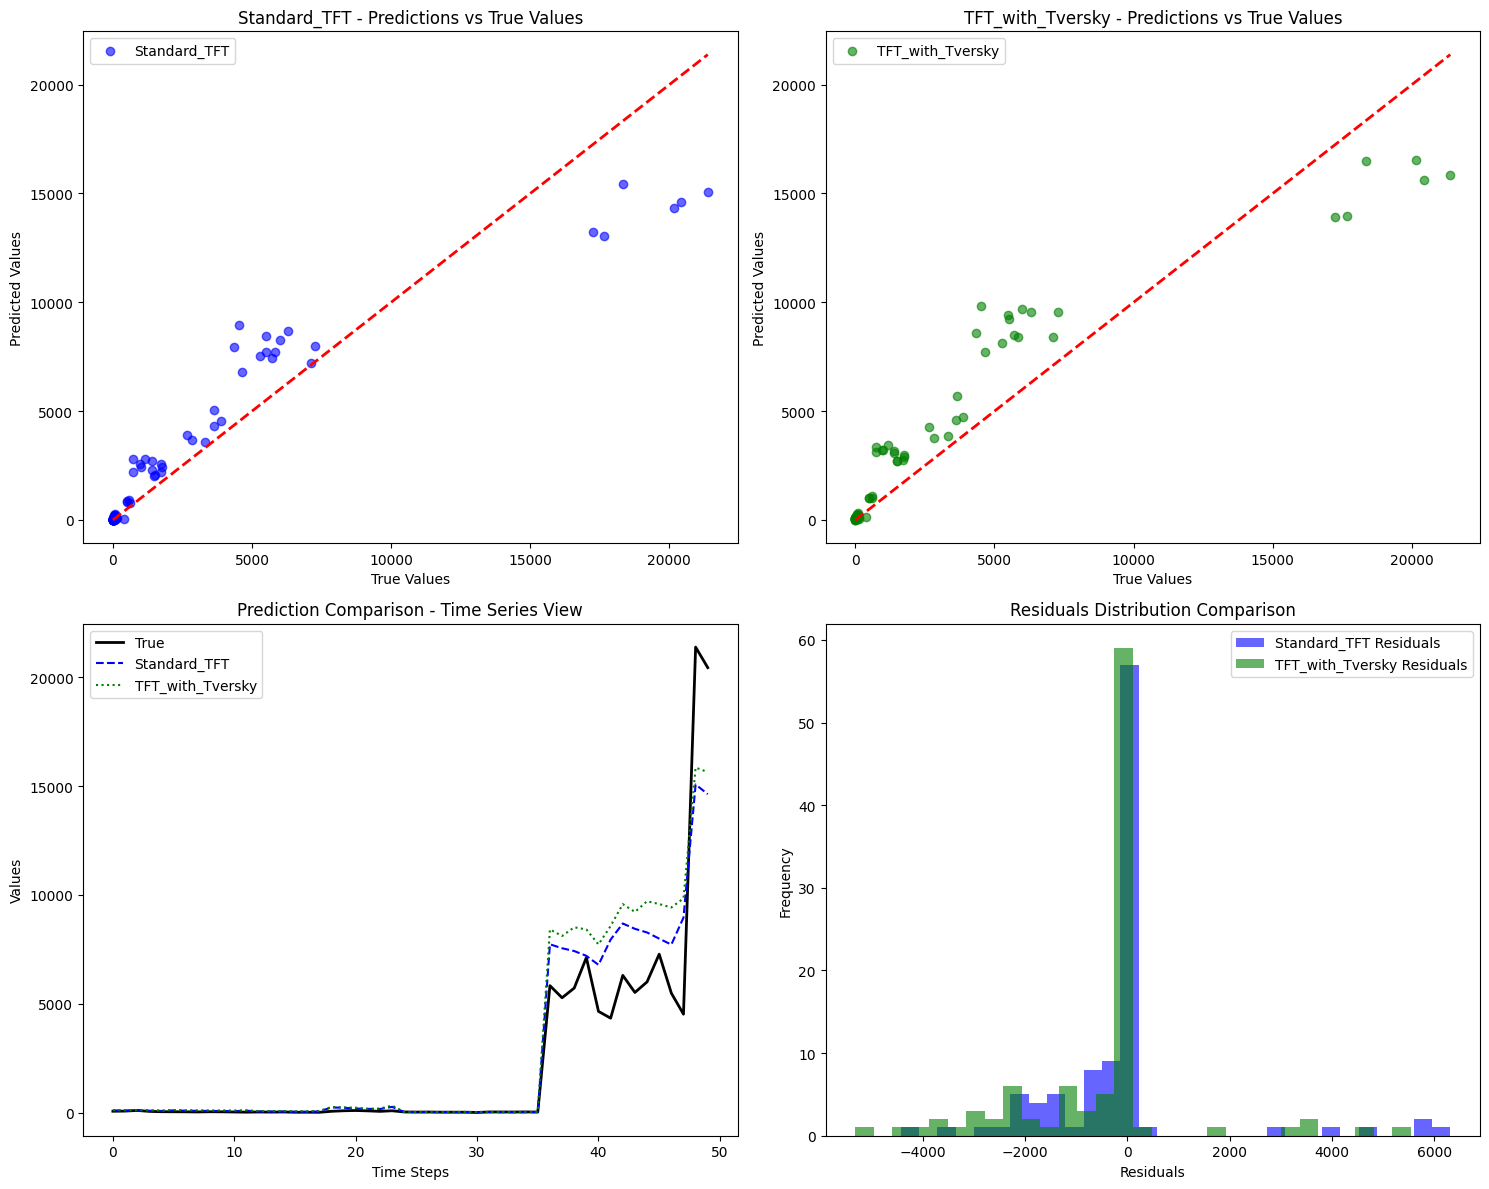


EXPERIMENT SUMMARY
Better performing model: TFT_with_Tversky
Validation loss improvement: 8.93%
✅ The Tversky output layer shows improvement over standard TFT!

Comparison results saved to 'model_comparison_results.csv'

🏁 Experiment completed successfully!


In [6]:
fig = plot_prediction_comparison(results_tft, results_tversky)

print(f"\n{'='*70}")
print("EXPERIMENT SUMMARY")
print(f"{'='*70}")

better_model = "TFT_with_Tversky" if results_tversky['val_loss'] < results_tft['val_loss'] else "Standard_TFT"
val_loss_improvement = abs((results_tft['val_loss'] - results_tversky['val_loss']) / results_tft['val_loss']) * 100

print(f"Better performing model: {better_model}")
print(f"Validation loss improvement: {val_loss_improvement:.2f}%")

if results_tversky['val_loss'] < results_tft['val_loss']:
    print("✅ The Tversky output layer shows improvement over standard TFT!")
else:
    print("❌ The Tversky output layer did not improve performance over standard TFT.")

comparison_df.to_csv('model_comparison_results.csv', index=False)
print(f"\nComparison results saved to 'model_comparison_results.csv'")

print(f"\n🏁 Experiment completed successfully!")